In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import segyio

In [3]:
def read_segy(filename):
    """
    read models and ignore headers
    Output:
    data - traces, times
    """
    with segyio.open(filename,ignore_geometry=True) as segyfile:
        segyfile.mmap()
        data = segyfile.trace.raw[:]
    data = np.squeeze(data)
    return data
data = read_segy('data/decon_data.segy')
data.shape

(600, 2001)

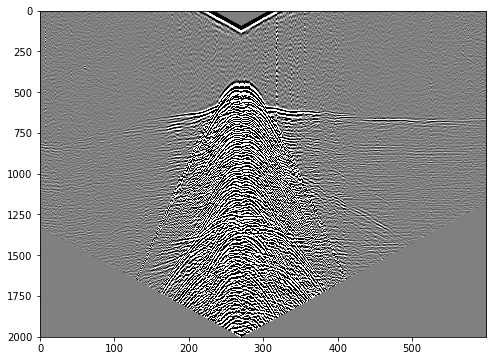

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
v = np.percentile(data,90)
ax.imshow(data.T,aspect='auto',vmin=-v,vmax=v,cmap='gray')

In [15]:
dat_ = signal.medfilt2d(data.T, kernel_size=3)
dat_ = signal.medfilt2d(dat_.T, kernel_size=3)
low_freq, high_freq, nyq_freq = 3,15,50
dat_ = butter_bandpass(dat_, low_freq, high_freq, nyq_freq, order=4)

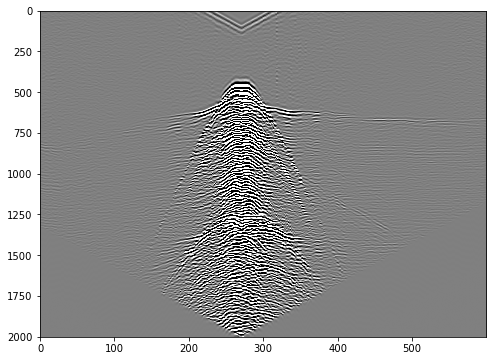

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
v = np.percentile(dat_,95)
ax.imshow(dat_.T,aspect='auto',vmin=-v,vmax=v,cmap='gray')

In [17]:
from scipy import signal as spysig
def butter_lowcut_op(cutoff, nyq_freq, order=4):
    """
    # Compute lowcut (highpass) filter operators
    """
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = spysig.butter(order, normal_cutoff, btype='high')
    return b, a

def butter_lowcut(data, cutoff_freq, nyq_freq, order=4):
    """
    # Apply lowcut filter to data
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    """
    b, a = butter_lowcut_op(cutoff_freq, nyq_freq, order=order)
    y = spysig.filtfilt(b, a, data)
    return y

def butter_highcut_op(cutoff, nyq_freq, order=4):
    """
    # Compute highcut (lowpass) filter operators
    """
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = spysig.butter(order, normal_cutoff, btype='low')
    return b, a

def butter_highcut(data, cutoff_freq, nyq_freq, order=4):
    """
    # Apply highcut filter to data
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    """
    b, a = butter_highcut_op(cutoff_freq, nyq_freq, order=order)
    y = spysig.filtfilt(b, a, data)
    return y

def butter_bandpass(data, low_freq, high_freq, nyq_freq, order=4):
    """
    # Apply bandpass filter to data
    """
    x = butter_lowcut(data, low_freq, nyq_freq, order=order)
    y = butter_highcut(x, high_freq, nyq_freq, order=order)
    return y